In [2]:
import cv2
import time
%matplotlib inline
import matplotlib.pyplot as plt
from yolo.yolo_predict import YoloPredict
yp = YoloPredict()

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


第一個模型成功
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

第二個模型成功
第三個模型成功
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

第四個模型成功
[01/20/2023-08:52:35] [TRT] [I] [MemUsageChange] Init CUDA: CPU +318, GPU +0, now: CPU 3125, GPU 4837 (MiB)
[01/20/2023-08:52:35] [TRT] [I] Loaded engine size: 72 MiB
[01/20/2023-08:52:35] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 3227, GPU 4917 (MiB)
[01/20/2023-08:52:35] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 3227, GPU 4927 (MiB)
[01/20/2023-08:52:35] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +70, now: CPU 0, GPU 70 (MiB)
[01/20/2023-08:52:35] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASL

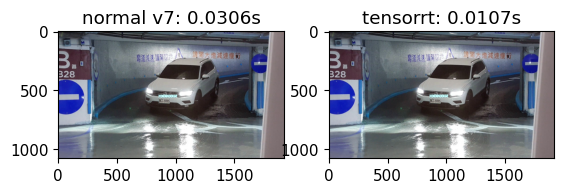

In [5]:

%matplotlib inline
img = cv2.imread("./yolo/images/00011.jpg")
t1 = time.time()
img = yp.predict(img)
end = time.time()-t1

# ====================================tensorrt

img2 = cv2.imread("./yolo/images/00011.jpg")
for i in range(1):
    t1 = time.time()
    img2,_ = yp.predict_trt(img2)
    end2 = time.time()-t1


plt.figure()
plt.subplot(1,2,1)
plt.title("normal v7: " + str(round(end,4))+"s")
plt.imshow(img)
          
plt.subplot(1,2,2)
plt.title("tensorrt: "+ str(round(end2,4))+"s")
plt.imshow(img2)
plt.show()

In [6]:
img2,_ = yp.predict_default(img2)

NameError: name 't2' is not defined

(640, 480, 3)
-----------1
-----------2
-----------3
-----------4
-----------5
-----------6
-----------7
-----------1
-----------2
-----------3
-----------4
-----------5
-----------8
---->seg_img (0, 19, 3)
抓不到匡
---->seg_img (0, 21, 3)
抓不到匡
-----------9
-----------10
-----------11
-----------12
-----------13


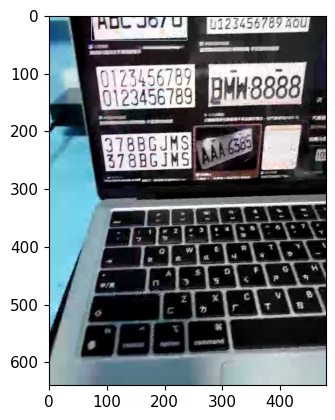

In [4]:
import cv2
import time
%matplotlib inline
import matplotlib.pyplot as plt

img2 = cv2.imread("./python_grey.png")
t1 = time.time()
img2 = yp.predict_trt(img2)
end2 = time.time()-t1

plt.imshow(img2)
plt.show()

In [8]:
cv2.resize(img2, (32, 32)).shape

(32, 32, 3)

In [2]:
round(1/0.0231,2)

43.29

In [1]:
class TRT_engine():
    def __init__(self, weight) -> None:
        self.imgsz = [416,416]
        self.weight = weight
        self.device = torch.device('cuda:0')
        self.init_engine()

    def init_engine(self):
        # Infer TensorRT Engine
        self.Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
        self.logger = trt.Logger(trt.Logger.INFO)
        trt.init_libnvinfer_plugins(self.logger, namespace="")
        with open(self.weight, 'rb') as self.f, trt.Runtime(self.logger) as self.runtime:
            self.model = self.runtime.deserialize_cuda_engine(self.f.read())
        self.bindings = OrderedDict()
        self.fp16 = False
        for index in range(self.model.num_bindings):
            self.name = self.model.get_binding_name(index)
            self.dtype = trt.nptype(self.model.get_binding_dtype(index))
            self.shape = tuple(self.model.get_binding_shape(index))
            self.data = torch.from_numpy(np.empty(self.shape, dtype=np.dtype(self.dtype))).to(self.device)
            self.bindings[self.name] = self.Binding(self.name, self.dtype, self.shape, self.data, int(self.data.data_ptr()))
            if self.model.binding_is_input(index) and self.dtype == np.float16:
                self.fp16 = True
        self.binding_addrs = OrderedDict((n, d.ptr) for n, d in self.bindings.items())
        self.context = self.model.create_execution_context()

    def letterbox(self,im,color=(114, 114, 114), auto=False, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        new_shape = self.imgsz
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)
        # Scale ratio (new / old)
        self.r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            self.r = min(self.r, 1.0)
        # Compute padding
        new_unpad = int(round(shape[1] * self.r)), int(round(shape[0] * self.r))
        self.dw, self.dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if auto:  # minimum rectangle
            self.dw, self.dh = np.mod(self.dw, stride), np.mod(self.dh, stride)  # wh padding
        self.dw /= 2  # divide padding into 2 sides
        self.dh /= 2
        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(self.dh - 0.1)), int(round(self.dh + 0.1))
        left, right = int(round(self.dw - 0.1)), int(round(self.dw + 0.1))
        self.img = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return self.img,self.r,self.dw,self.dh

    def preprocess(self,image):
        self.img,self.r,self.dw,self.dh = self.letterbox(image)
        self.img = self.img.transpose((2, 0, 1))
        self.img = np.expand_dims(self.img,0)
        self.img = np.ascontiguousarray(self.img)
        self.img = torch.from_numpy(self.img).to(self.device)
        self.img = self.img.float()
        return self.img

    def predict(self,img,threshold):
        img = self.preprocess(img)
        self.binding_addrs['images'] = int(img.data_ptr())
        self.context.execute_v2(list(self.binding_addrs.values()))
        nums = self.bindings['num_dets'].data[0].tolist()
        boxes = self.bindings['det_boxes'].data[0].tolist()
        scores =self.bindings['det_scores'].data[0].tolist()
        classes = self.bindings['det_classes'].data[0].tolist()
        num = int(nums[0])
        new_bboxes = []
        for i in range(num):
            if(scores[i] < threshold):
                continue
            xmin = (boxes[i][0] - self.dw)/self.r
            ymin = (boxes[i][1] - self.dh)/self.r
            xmax = (boxes[i][2] - self.dw)/self.r
            ymax = (boxes[i][3] - self.dh)/self.r
            new_bboxes.append([classes[i],scores[i],xmin,ymin,xmax,ymax])
        return new_bboxes


In [4]:
import time
import numpy as np
import os
import cv2
import torch
import tensorrt as trt
from collections import OrderedDict,namedtuple

trt_engine = TRT_engine("./output_rt/best1.engine")


[01/19/2023-15:36:07] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[01/19/2023-15:36:07] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 2516, GPU 1273 (MiB)
[01/19/2023-15:36:07] [TRT] [I] Loaded engine size: 72 MiB
[01/19/2023-15:36:07] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2597, GPU 1355 (MiB)
[01/19/2023-15:36:07] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 2597, GPU 1365 (MiB)
[01/19/2023-15:36:07] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +70, now: CPU 0, GPU 166 (MiB)
[01/19/2023-15:36:07] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2525, GPU 1357 (MiB)
[01/19/2023-15:36:07] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2525, GPU 

In [ ]:
apt install gunicorn -y
pip install Flask-Migrate
pip install Flask-Cors
pip install flask-login
pip install nvidia-tensorrt==8.4.1.5
apt install gunicorn

In [18]:
list1 = [1]

In [20]:
list1.append(1)[:3]

TypeError: 'NoneType' object is not subscriptable